Media de innovaciones log (obs - pred): 0.0066
Desviación estándar en log: 0.6330
(* Cero implica buen balance medio *)
------------------------------------
RMSE: 418.3  MAE: 170.9  MAPE: 23.2%
sMAPE: 23.2%  MAE_log: 0.315
Media de innovación (log) móvil 12 sem.: -0.0070


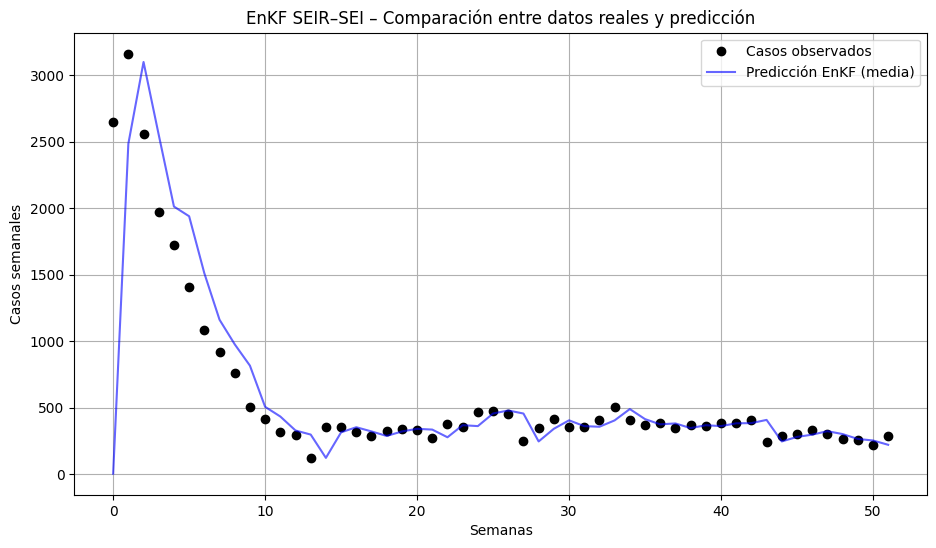

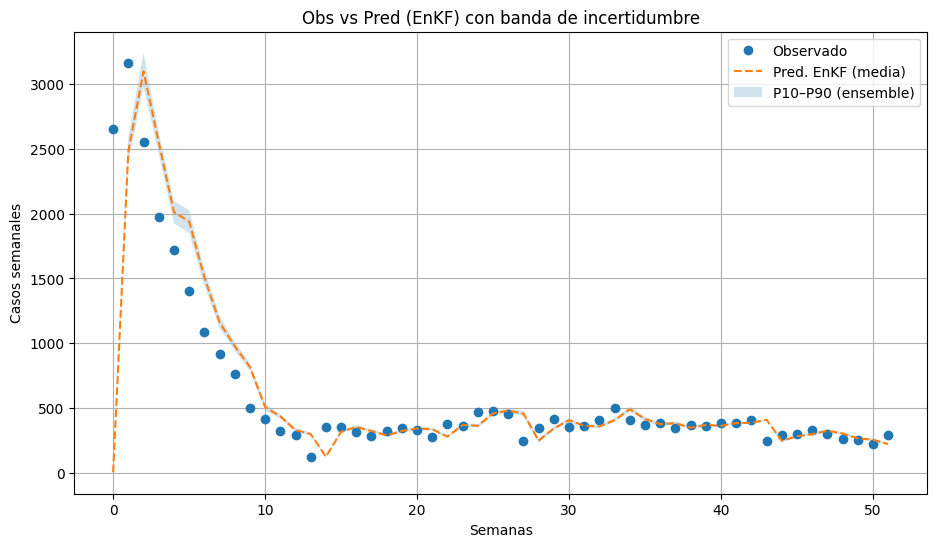

EnKF → RMSE=418.3  MAE=170.9  MAPE=23.2%  sMAPE=23.2%  MAE_log=0.315


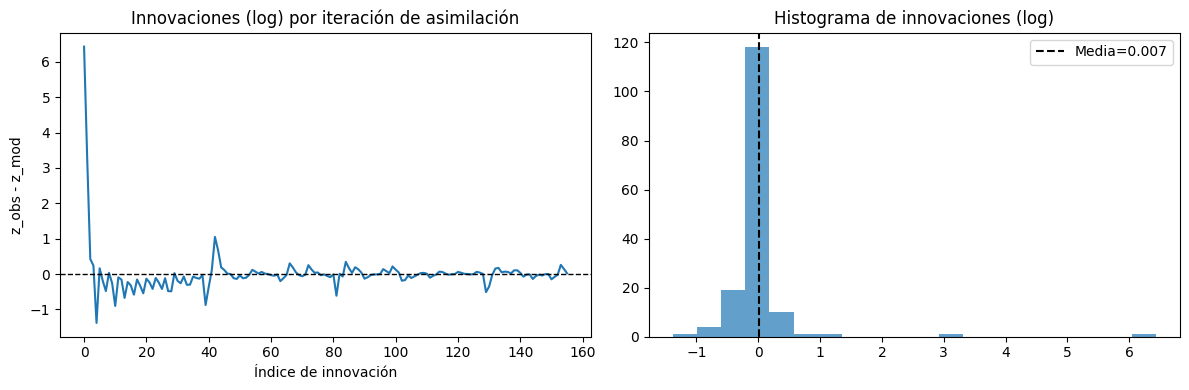

Media innovación (log): 0.0066  |  Desv.Est.: 0.6330


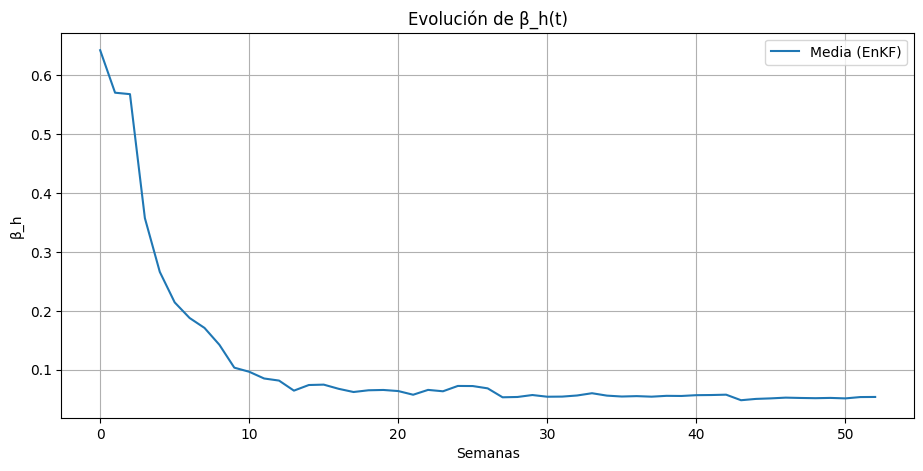

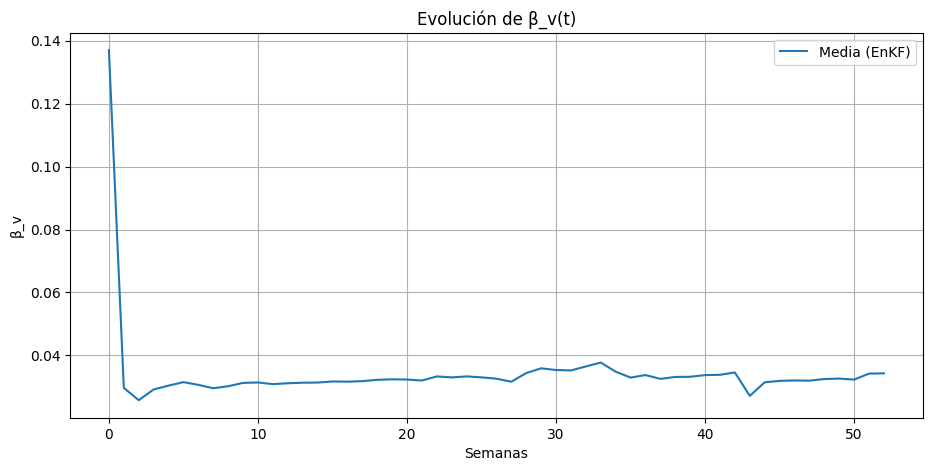

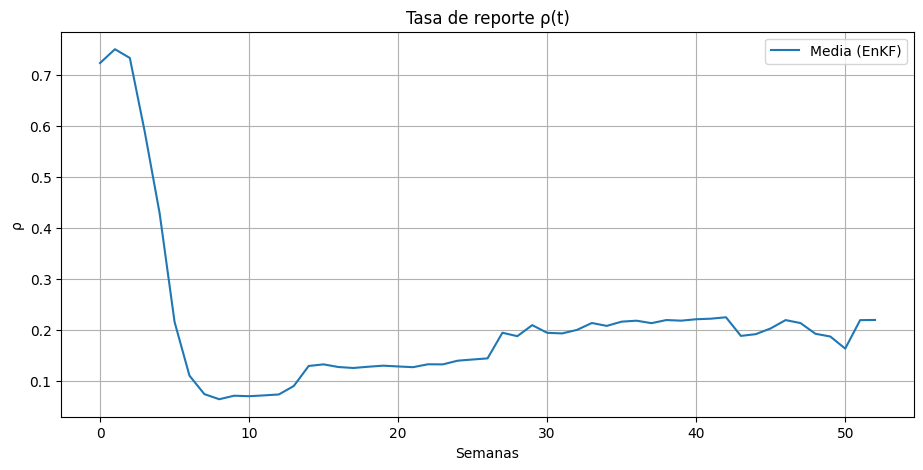

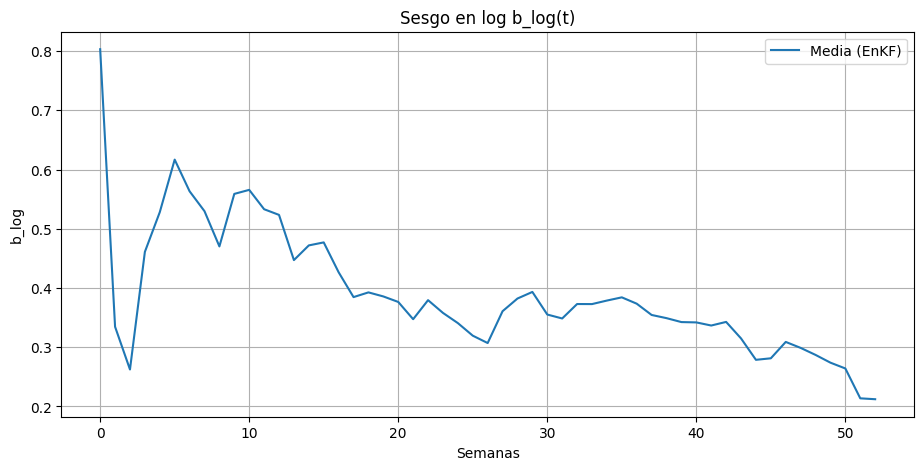

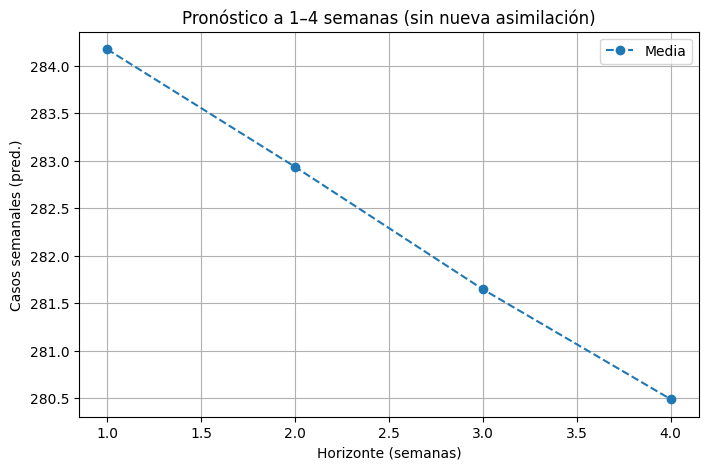

Baseline → RMSE=13372.0  MAE=6034.6  MAPE=1886.3%  sMAPE=166.6%  MAE_log=3.554

Mejora relativa (Baseline → EnKF):
  RMSE   : 96.9%
  MAE    : 97.2%
  MAPE   : 98.8%
  SMAPE  : 86.1%
  MAE_LOG: 91.1%


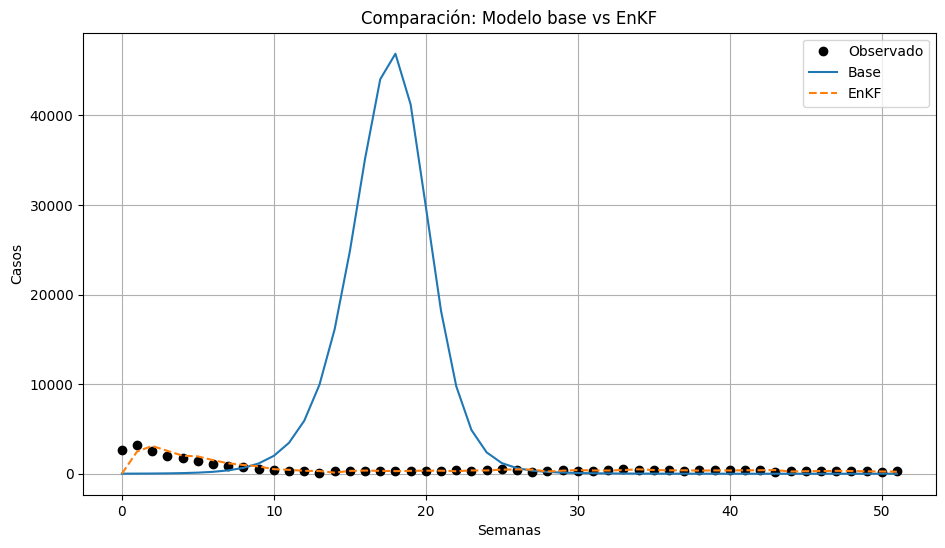

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import savgol_filter

np.random.seed(42)

# ============================================================
# Utilidades
# ============================================================
def sigmoid(z):
    return 1/(1+np.exp(-z))

def logit(p):
    p = np.clip(p, 1e-6, 1-1e-6)
    return np.log(p/(1-p))

def moving_average(x, window=5):
    return np.convolve(x, np.ones(window)/window, mode='same')

# ============================================================
# Parámetros base del modelo SEIR–SEI
# ============================================================
params_base = {
    'alpha_h': 1/5,     # incubación humana
    'alpha_v': 1/10,    # incubación vectorial
    'gamma_h': 1/7,     # recuperación humana
    'mu_h': 1/(70*365), # mortalidad humana
    'mu_v': 1/14,       # mortalidad vectorial
    'Nh': 1_000_000,
    'Nv': 10_000_000
}

# ============================================================
# Observaciones (casos semanales)
# ============================================================
obs_data = np.array([
    2650, 3160, 2556, 1974, 1720, 1404, 1085, 917, 765, 503, 418, 320, 295, 124, 355, 354, 315, 286,
    325, 342, 332, 275, 377, 358, 466, 478, 455, 247, 349, 415, 356, 358, 411, 503, 406, 371, 385,
    345, 372, 362, 385, 384, 410, 245, 289, 301, 331, 301, 263, 255, 219, 288
], dtype=float)

# ============================================================
# Dinámica semanal con incidencia integrada
# ============================================================
def step_one_week_with_incidence(y_init, params_dyn, rho, t0, dt=7.0):
    def f_aug(t, y_aug):
        y = y_aug[:-1]
        Sh, Eh, Ih, Rh, Sv, Ev, Iv = y
        Nh = params_dyn['Nh']; Nv = params_dyn['Nv']
        beta_h = params_dyn['beta_h']; beta_v = params_dyn['beta_v']
        ah = params_dyn['alpha_h']; av = params_dyn['alpha_v']
        gh = params_dyn['gamma_h']; muh = params_dyn['mu_h']; muv = params_dyn['mu_v']

        dSh = muh*Nh - beta_h*Sh*Iv/Nh - muh*Sh
        dEh = beta_h*Sh*Iv/Nh - (ah+muh)*Eh
        dIh = ah*Eh - (gh+muh)*Ih
        dRh = gh*Ih - muh*Rh

        dSv = muv*Nv - beta_v*Sv*Ih/Nh - muv*Sv
        dEv = beta_v*Sv*Ih/Nh - (av+muv)*Ev
        dIv = av*Ev - muv*Iv

        dC  = rho * ah * Eh  # incidencia reportada acumulada
        return np.array([dSh, dEh, dIh, dRh, dSv, dEv, dIv, dC])

    y_aug0 = np.concatenate([y_init, [0.0]])
    sol = solve_ivp(f_aug, (t0, t0+dt), y_aug0, max_step=1.0)
    y_end = sol.y[:-1, -1]
    cases_week = sol.y[-1, -1]
    return y_end, cases_week

# ============================================================
# EnKF en log-espacio (inflación sólo en estados)
# ============================================================
def enkf_update_logspace(ensemble, Z_model, z_obs, Rz, state_dim, inflation=1.0):
    n, N = ensemble.shape
    m, Ny = Z_model.shape
    assert Ny == N and m == 1

    x_mean = np.mean(ensemble, axis=1, keepdims=True)
    z_mean = np.mean(Z_model, axis=1, keepdims=True)
    Xc = ensemble - x_mean
    Zc = Z_model - z_mean

    if inflation != 1.0:
        # Inflar sólo los estados (no parámetros ni b_log)
        Xc_states = np.zeros_like(Xc)
        Xc_states[:state_dim, :] = Xc[:state_dim, :]
        Xc = Xc + (inflation - 1.0) * Xc_states
        Zc *= inflation

    Pxz = (Xc @ Zc.T) / (N - 1)
    Pz  = (Zc @ Zc.T) / (N - 1)
    S = Pz + Rz
    K = Pxz @ np.linalg.inv(S)

    L = np.linalg.cholesky(Rz)
    pert = (L @ np.random.normal(size=(m, N)))
    innov = (z_obs.reshape(-1,1) + pert) - Z_model

    ensemble_a = ensemble + K @ innov
    # Cortes físicos para estados
    ensemble_a[:state_dim, :] = np.clip(ensemble_a[:state_dim, :], 0.0, None)
    return ensemble_a

# ============================================================
# Configuración del EnKF (estado aumentado)
# ============================================================
state_dim = 7
param_dim = 3
bias_dim  = 1
aug_dim = state_dim + param_dim + bias_dim

N_ens = 180
inflation_base = 1.00
Rz = np.array([[0.055**2]])  # varianza en log

y0 = np.array([params_base['Nh'] - 10, 5, 5, 0, params_base['Nv'] - 100, 50, 50], dtype=float)
beta_h0, beta_v0, rho0, b_log0 = 0.12, 0.10, 0.30, -1.0
theta0 = np.array([np.log(beta_h0), np.log(beta_v0), logit(rho0), b_log0], dtype=float)

state_spread = np.array([200, 50, 50, 50, 500, 80, 80], dtype=float)
param_spread = np.array([0.20, 0.20, 0.30, 0.20], dtype=float)

ensemble = np.zeros((aug_dim, N_ens))
for j in range(N_ens):
    ensemble[:state_dim, j] = np.clip(y0 + np.random.normal(0, state_spread), 0.0, None)
    ensemble[state_dim:, j] = theta0 + np.random.normal(0, param_spread)

# Ruido de proceso (menos en b_log)
proc_std_states = np.array([40, 8, 8, 8, 80, 15, 15], dtype=float)
proc_std_params = np.array([0.04, 0.04, 0.06, 0.03])  # b_log más suave

# ============================================================
# Arreglos para guardar trayectorias por miembro (para bandas)
# ============================================================
dt = 7
t_range = np.arange(0, 365, dt)
T = len(t_range)

pred_cases_ens = np.full((T, N_ens), np.nan)
beta_h_ens = np.full((T, N_ens), np.nan)
beta_v_ens = np.full((T, N_ens), np.nan)
rho_ens    = np.full((T, N_ens), np.nan)
blog_ens   = np.full((T, N_ens), np.nan)

# ============================================================
# Bucle principal
# ============================================================
est_states, innovations = [], []
pred_cases_series, beta_h_series, beta_v_series, rho_series, b_log_series = [], [], [], [], []

for k, t in enumerate(t_range):
    Z_model = np.empty((1, N_ens))
    raw_cases = []

    # ----- Predicción por miembro -----
    for j in range(N_ens):
        xj = ensemble[:state_dim, j]
        th = ensemble[state_dim:, j]
        log_bh, log_bv, logit_rho, b_log = th
        beta_h_j, beta_v_j, rho_j = np.exp(log_bh), np.exp(log_bv), sigmoid(logit_rho)
        params_dyn = dict(params_base, beta_h=float(beta_h_j), beta_v=float(beta_v_j))
        x_end, cases_week = step_one_week_with_incidence(xj, params_dyn, float(rho_j), t)

        # Renormalización poblacional
        Sh, Eh, Ih, Rh, Sv, Ev, Iv = x_end
        Nh, Nv = params_base['Nh'], params_base['Nv']
        sum_h, sum_v = Sh+Eh+Ih+Rh, Sv+Ev+Iv
        if sum_h > 0:
            Sh, Eh, Ih, Rh = (Sh*Nh/sum_h, Eh*Nh/sum_h, Ih*Nh/sum_h, Rh*Nh/sum_h)
        if sum_v > 0:
            Sv, Ev, Iv = (Sv*Nv/sum_v, Ev*Nv/sum_v, Iv*Nv/sum_v)
        ensemble[:state_dim, j] = [Sh, Eh, Ih, Rh, Sv, Ev, Iv]

        # Operador de observación en log
        z = np.log1p(max(cases_week, 0.0)) + float(b_log)
        Z_model[0, j] = z

        # *** Inversa correcta para guardar predicción en escala natural ***
        raw_cases.append(np.expm1(np.log1p(cases_week) + float(b_log)))

    raw_cases = np.array(raw_cases)

    # ---- Guardar trayectorias por miembro para bandas ----
    pred_cases_ens[k, :] = raw_cases
    bh = np.exp(ensemble[state_dim+0, :])
    bv = np.exp(ensemble[state_dim+1, :])
    rr = sigmoid(ensemble[state_dim+2, :])
    bl = ensemble[state_dim+3, :]
    beta_h_ens[k, :], beta_v_ens[k, :], rho_ens[k, :], blog_ens[k, :] = bh, bv, rr, bl

    # ---- Inflación adaptativa ligera (sólo estados dentro del update) ----
    spread_z = float(np.std(Z_model))
    target_spread = 0.6
    inflation_adapt = inflation_base + (min(0.05, 0.5*(spread_z - target_spread)/target_spread)
                                        if spread_z > target_spread else 0.0)

    # ---- Dinámica previa de b_log: AR(1) suave hacia 0 ----
    phi = 0.98
    ensemble[state_dim+3, :] = phi * ensemble[state_dim+3, :]

    # ---- Ruido de proceso ----
    ensemble[:state_dim, :] = np.clip(
        ensemble[:state_dim, :] + np.random.normal(0, proc_std_states.reshape(-1,1), (state_dim, N_ens)),
        0.0, None
    )
    ensemble[state_dim:, :] += np.random.normal(0, proc_std_params.reshape(-1,1), (param_dim + bias_dim, N_ens))

    # ---- Re-cortes suaves de parámetros ----
    log_bh, log_bv, logit_r, b_log = ensemble[state_dim+0, :], ensemble[state_dim+1, :], ensemble[state_dim+2, :], ensemble[state_dim+3, :]
    beta_h, beta_v, rho = np.exp(log_bh), np.exp(log_bv), sigmoid(logit_r)
    beta_h, beta_v, rho = np.clip(beta_h, 0.05, 0.60), np.clip(beta_v, 0.03, 0.50), np.clip(rho, 0.05, 0.90)
    ensemble[state_dim+0, :], ensemble[state_dim+1, :], ensemble[state_dim+2, :], ensemble[state_dim+3, :] = \
        np.log(beta_h), np.log(beta_v), logit(rho), np.clip(b_log, -3.0, 1.0)

    # ---- Asimilación ----
    if k < len(obs_data):
        z_obs = np.array([np.log1p(obs_data[k])])

        # Escalado adaptativo del ruido de observación (ventana móvil)
        win = 12
        if len(innovations) >= win:
            innov_win = np.array(innovations[-win:])
            var_emp = float(np.var(innov_win))
            var_nom = float(Rz[0,0])
            scale = np.clip(var_emp / max(var_nom, 1e-9), 0.5, 2.0)
        else:
            scale = 1.0
        Rz_eff = Rz * scale

        # EnKF iterado (3 pasadas)
        for _ in range(3):
            innovations.append(z_obs[0] - np.mean(Z_model))
            ensemble = enkf_update_logspace(
                ensemble, Z_model, z_obs, Rz_eff/3.0, state_dim=state_dim, inflation=inflation_adapt
            )
            # Re-evaluar Z_model tras la actualización
            for j in range(N_ens):
                xj = ensemble[:state_dim, j]
                th = ensemble[state_dim:, j]
                log_bh, log_bv, logit_rho, b_log = th
                beta_h_j, beta_v_j, rho_j = np.exp(log_bh), np.exp(log_bv), sigmoid(logit_rho)
                params_dyn = dict(params_base, beta_h=float(beta_h_j), beta_v=float(beta_v_j))
                _, cases_week_tmp = step_one_week_with_incidence(xj, params_dyn, float(rho_j), t)
                Z_model[0, j] = np.log1p(max(cases_week_tmp, 0.0)) + float(b_log)

    # ---- Registro de series (media del ensemble) ----
    est_states.append(np.mean(ensemble[:state_dim, :], axis=1))
    pred_cases_series.append(np.mean(raw_cases))
    beta_h_series.append(np.exp(np.mean(ensemble[state_dim+0, :])))
    beta_v_series.append(np.exp(np.mean(ensemble[state_dim+1, :])))
    rho_series.append(sigmoid(np.mean(ensemble[state_dim+2, :])))
    b_log_series.append(np.mean(ensemble[state_dim+3, :]))

innovations = np.array(innovations)
pred_cases_series = np.array(pred_cases_series)
beta_h_series = np.array(beta_h_series)
beta_v_series = np.array(beta_v_series)
rho_series = np.array(rho_series)
b_log_series = np.array(b_log_series)

# ============================================================
# Métricas
# ============================================================
pred, obs = pred_cases_series[:len(obs_data)], obs_data
rmse = np.sqrt(np.mean((obs - pred)**2))
mae = np.mean(np.abs(obs - pred))
mape = np.mean(np.abs((obs - pred)/np.maximum(obs,1))) * 100
smape = 100*np.mean(2*np.abs(pred-obs)/(np.abs(pred)+np.abs(obs)+1e-9))
mae_log = np.mean(np.abs(np.log1p(pred)-np.log1p(obs)))

print("====================================")
print(f"Media de innovaciones log (obs - pred): {innovations.mean():.4f}")
print(f"Desviación estándar en log: {innovations.std():.4f}")
print("(* Cero implica buen balance medio *)")
print("------------------------------------")
print(f"RMSE: {rmse:.1f}  MAE: {mae:.1f}  MAPE: {mape:.1f}%")
print(f"sMAPE: {smape:.1f}%  MAE_log: {mae_log:.3f}")
# Media móvil de innovaciones (12 semanas)
if len(innovations) >= 12:
    mu_w = np.convolve(innovations, np.ones(12)/12, mode='valid')
    print(f"Media de innovación (log) móvil 12 sem.: {mu_w[-1]:.4f}")
print("====================================")

# ============================================================
# Gráficas base
# ============================================================
weeks = np.arange(len(obs_data))
pred_aligned = pred
sg = savgol_filter(pred_aligned, window_length=7, polyorder=2)

plt.figure(figsize=(11,6))
plt.plot(weeks, obs_data, 'o', color='black', label='Casos observados')
plt.plot(weeks, pred_aligned, '-', color='blue', alpha=0.6, label='Predicción EnKF (media)')
plt.title("EnKF SEIR–SEI – Comparación entre datos reales y predicción")
plt.xlabel("Semanas")
plt.ylabel("Casos semanales")
plt.legend(); plt.grid(True); plt.show()

# ============================================================
# Obs vs Pred con banda P10–P90
# ============================================================
has_ens_cases = np.isfinite(pred_cases_ens[:len(obs_data), :]).all(axis=1).any()
if has_ens_cases:
    p10 = np.nanpercentile(pred_cases_ens[:len(obs_data), :], 10, axis=1)
    p90 = np.nanpercentile(pred_cases_ens[:len(obs_data), :], 90, axis=1)
else:
    p10 = p90 = pred

plt.figure(figsize=(11,6))
plt.plot(weeks, obs_data, 'o', label='Observado')
plt.plot(weeks, pred, '--', label='Pred. EnKF (media)')
plt.fill_between(weeks, p10, p90, alpha=0.2, label='P10–P90 (ensemble)')
plt.title('Obs vs Pred (EnKF) con banda de incertidumbre')
plt.xlabel('Semanas'); plt.ylabel('Casos semanales')
plt.legend(); plt.grid(True); plt.show()

# ============================================================
# Métricas (función utilitaria)
# ============================================================
def report_metrics(y_true, y_pred, prefix=''):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mae  = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred)/np.maximum(y_true,1))) * 100
    smape = 100*np.mean(2*np.abs(y_pred - y_true)/(np.abs(y_pred)+np.abs(y_true)+1e-9))
    mae_log = np.mean(np.abs(np.log1p(y_pred) - np.log1p(y_true)))
    print(f"{prefix}RMSE={rmse:.1f}  MAE={mae:.1f}  MAPE={mape:.1f}%  sMAPE={smape:.1f}%  MAE_log={mae_log:.3f}")
    return dict(rmse=rmse, mae=mae, mape=mape, smape=smape, mae_log=mae_log)

m_enkf = report_metrics(obs_data, pred, prefix='EnKF → ')

# ============================================================
# Innovaciones en log
# ============================================================
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(innovations, '-')
ax[0].axhline(0, color='k', lw=1, ls='--')
ax[0].set_title('Innovaciones (log) por iteración de asimilación')
ax[0].set_xlabel('Índice de innovación'); ax[0].set_ylabel('z_obs - z_mod')

ax[1].hist(innovations, bins=20, alpha=0.7)
ax[1].axvline(np.mean(innovations), color='k', ls='--', label=f"Media={np.mean(innovations):.3f}")
ax[1].set_title('Histograma de innovaciones (log)')
ax[1].legend()
plt.tight_layout(); plt.show()

print(f"Media innovación (log): {np.mean(innovations):.4f}  |  Desv.Est.: {np.std(innovations):.4f}")

# ============================================================
# Parámetros y sesgo (trazas)
# ============================================================
def plot_series(series_mean, title, ylabel):
    Tplot = len(series_mean)
    w = np.arange(Tplot)
    plt.figure(figsize=(11,5))
    plt.plot(w, series_mean, label='Media (EnKF)')
    plt.title(title); plt.xlabel('Semanas'); plt.ylabel(ylabel)
    plt.grid(True); plt.legend(); plt.show()

plot_series(beta_h_series[:T], 'Evolución de β_h(t)', 'β_h')
plot_series(beta_v_series[:T], 'Evolución de β_v(t)', 'β_v')
plot_series(rho_series[:T],    'Tasa de reporte ρ(t)', 'ρ')
plot_series(b_log_series[:T],  'Sesgo en log b_log(t)', 'b_log')

# ============================================================
# Pronóstico a 1–4 semanas (sin nueva asimilación)
# ============================================================
def forecast_weeks_ahead(ensemble_final, k_weeks, params_base, dt=7):
    """Propaga el ensemble k semanas sin asimilación; devuelve matriz [k, N_ens] de casos."""
    N = ensemble_final.shape[1]
    fcst = np.zeros((k_weeks, N))
    for j in range(N):
        xj = ensemble_final[:state_dim, j].copy()
        log_bh, log_bv, logit_rho, b_log = ensemble_final[state_dim:, j]
        for k in range(k_weeks):
            beta_h_j = float(np.exp(log_bh)); beta_v_j = float(np.exp(log_bv))
            rho_j = float(1/(1+np.exp(-logit_rho)))
            params_dyn = dict(params_base, beta_h=beta_h_j, beta_v=beta_v_j)
            xj, cases_week = step_one_week_with_incidence(xj, params_dyn, rho_j, t0=0.0, dt=dt)
            # *** Inversa correcta ***
            fcst[k, j] = np.expm1(np.log1p(cases_week) + float(b_log))
            # Renormalización
            Sh, Eh, Ih, Rh, Sv, Ev, Iv = xj
            Nh, Nv = params_base['Nh'], params_base['Nv']
            sum_h, sum_v = Sh+Eh+Ih+Rh, Sv+Ev+Iv
            if sum_h > 0:
                xj[:4] = xj[:4] * Nh / sum_h
            if sum_v > 0:
                xj[4:] = xj[4:] * Nv / sum_v
    return fcst  # [k, N]

ensemble_final = ensemble.copy()
fcst_mat = forecast_weeks_ahead(ensemble_final, k_weeks=4, params_base=params_base, dt=7)
fcst_mean = fcst_mat.mean(axis=1)

horizons = np.arange(1, 5)
plt.figure(figsize=(8,5))
plt.plot(horizons, fcst_mean, 'o--', label='Media')
plt.title('Pronóstico a 1–4 semanas (sin nueva asimilación)')
plt.xlabel('Horizonte (semanas)'); plt.ylabel('Casos semanales (pred.)')
plt.grid(True); plt.legend(); plt.show()

# ============================================================
# Baseline determinista (sin EnKF) y mejora vs EnKF
# ============================================================
def simulate_baseline(y0, params_base, beta_h, beta_v, rho, weeks_len, dt=7, b_log=0.0):
    x = y0.copy()
    Nh, Nv = params_base['Nh'], params_base['Nv']
    out = []
    t = 0.0
    for k in range(weeks_len):
        params_dyn = dict(params_base, beta_h=float(beta_h), beta_v=float(beta_v))
        x, cases_week = step_one_week_with_incidence(x, params_dyn, float(rho), t0=t, dt=dt)
        # *** Inversa correcta ***
        out.append(np.expm1(np.log1p(cases_week) + float(b_log)))
        # Renormaliza
        Sh, Eh, Ih, Rh, Sv, Ev, Iv = x
        sum_h, sum_v = Sh+Eh+Ih+Rh, Sv+Ev+Iv
        if sum_h > 0:
            x[:4] = x[:4] * Nh / sum_h
        if sum_v > 0:
            x[4:] = x[4:] * Nv / sum_v
        t += dt
    return np.array(out)

baseline_pred = simulate_baseline(
    y0=np.array([params_base['Nh'] - 10, 5, 5, 0, params_base['Nv'] - 100, 50, 50], dtype=float),
    params_base=params_base,
    beta_h=0.12, beta_v=0.10, rho=0.30,
    weeks_len=len(obs_data),
    dt=7,
    b_log=0.0
)

m_base = report_metrics(obs_data, baseline_pred, prefix='Baseline → ')
print("\nMejora relativa (Baseline → EnKF):")
for k in ['rmse','mae','mape','smape','mae_log']:
    v0, v1 = m_base[k], m_enkf[k]
    print(f"  {k.upper():7s}: {((v0 - v1)/max(v0,1e-9)*100):.1f}%")
plt.figure(figsize=(11,6))
plt.plot(weeks, obs_data, 'ko', label='Observado')
plt.plot(weeks, baseline_pred, '-', label='Base')
plt.plot(weeks, pred, '--', label='EnKF')
plt.title('Comparación: Modelo base vs EnKF')
plt.xlabel('Semanas'); plt.ylabel('Casos')
plt.grid(True); plt.legend(); plt.show()
